In [3]:
import re
import nltk
import numpy as np
import torch 

from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random
import pandas as pd
from datasets import Dataset 

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation,util
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
 #Download NLTK data files (run once)
# nltk.download('reuters')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

In [2]:
# Get file IDs and categories
file_ids = reuters.fileids()
categories = reuters.categories()

# Load articles and their labels
articles = [reuters.raw(file_id) for file_id in file_ids]
labels = [reuters.categories(file_id)[0] for file_id in file_ids]  # Use the first category as the label

# Create a DataFrame for easier analysis
df = pd.DataFrame({'text': articles, 'label': labels})

### 1.2. Basic Statistics

In [3]:
df.head(10)

,text,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,trade
1,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,grain
2,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,crude
3,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n ...,corn
4,INDONESIA SEES CPO PRICE RISING SHARPLY\n Ind...,palm-oil
5,AUSTRALIAN FOREIGN SHIP BAN ENDS BUT NSW PORTS...,ship
6,INDONESIAN COMMODITY EXCHANGE MAY EXPAND\n Th...,coffee
7,SRI LANKA GETS USDA APPROVAL FOR WHEAT PRICE\n...,grain
8,WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRA...,gold
9,SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERG...,acq


In [4]:
df.describe()

,text,label
count,10788,10788
unique,10657,79
top,26-FEB-1987\n 26-FEB-1987\n\n,earn
freq,7,3926


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10788 non-null  object
 1   label   10788 non-null  object
dtypes: object(2)
memory usage: 168.7+ KB


In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

Total articles: 10788
Unique categories: 79
label
earn             3926
acq              2369
crude             552
interest          453
money-fx          362
                 ... 
copra-cake          1
groundnut-oil       1
cotton-oil          1
sun-oil             1
rand                1
Name: count, Length: 79, dtype: int64


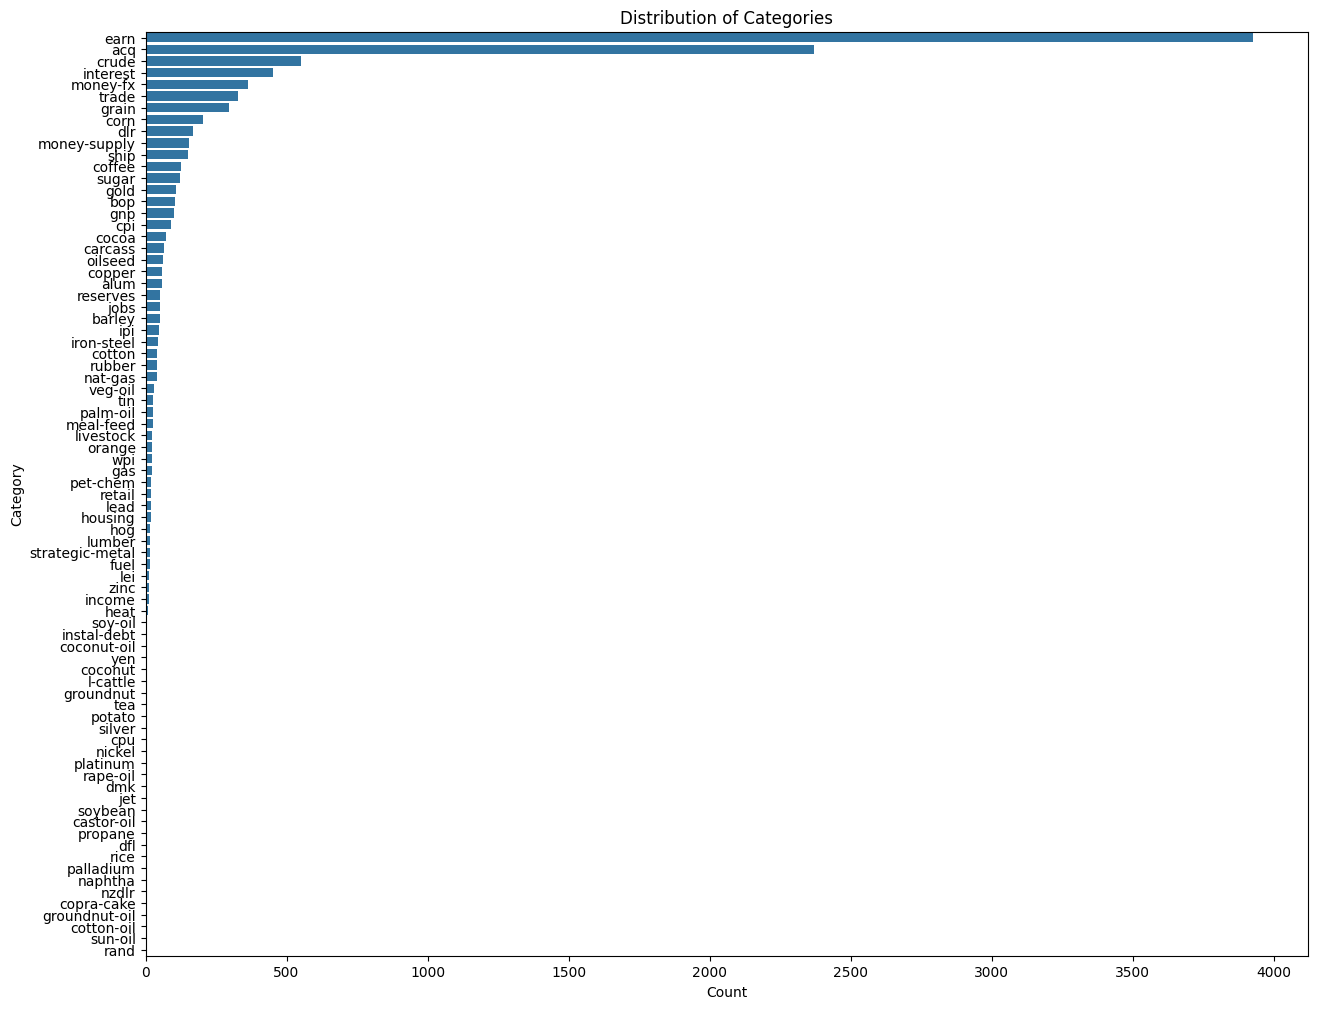

In [7]:
# Number of articles
print(f"Total articles: {len(df)}")

# Number of unique categories
print(f"Unique categories: {df['label'].nunique()}")

# Distribution of categories
print(df['label'].value_counts())

# Plot the distribution of categories
plt.figure(figsize=(15, 12))
sns.countplot(y=df['label'], order=df['label'].value_counts().index)
plt.title("Distribution of Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

label
earn             3926
acq              2369
crude             552
interest          453
money-fx          362
                 ... 
copra-cake          1
groundnut-oil       1
cotton-oil          1
sun-oil             1
rand                1
Name: count, Length: 79, dtype: int64


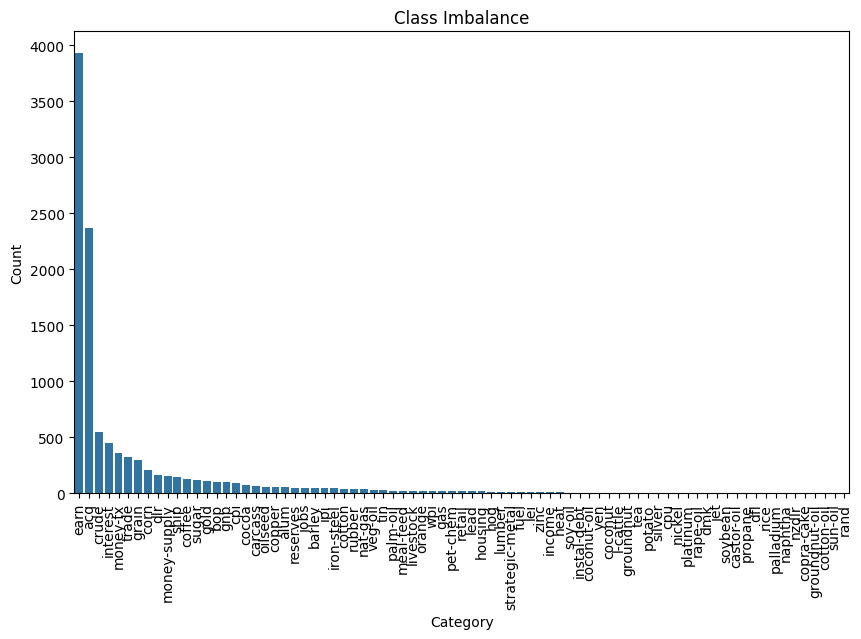

In [8]:
# Check class imbalance
category_counts = df['label'].value_counts()
print(category_counts)

# Plot class imbalance
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Class Imbalance")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [9]:
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    """
    Preprocesses the input text by:
    1. Converting to lowercase.
    2. Removing special characters and numbers.
    3. Tokenizing into words.
    4. Lemmatizing words.
    """
    # Lowercase the text
    text = text.lower()  
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z0-9']", " ", text)  
    # Tokenize into words
    words = word_tokenize(text)  
    # Remove single-character words
    words = [word for word in words if len(word) > 1]  
    # Remove stopwords
    words = [word for word in words if word not in stop_words]  
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the dataset
df['cleaned_text'] = df['text'].apply(preprocess)

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# Use the first sentence as the query
train_df['query'] = train_df['cleaned_text'].apply(lambda x: x.split('.')[0])

# Create synthetic pairs
query_article_pairs = []
for i, row in train_df.iterrows():
    query = row['query']
    article = row['cleaned_text']
    relevant_pair = (query, article, 1.0)  # Relevant pair (same article)
    query_article_pairs.append(relevant_pair)

    # Create an irrelevant pair (random article from a different category)
    random_row = train_df[train_df['label'] != row['label']].sample(1).iloc[0]
    irrelevant_pair = (query, random_row['cleaned_text'], 0.0)  # Irrelevant pair
    query_article_pairs.append(irrelevant_pair)

# Split into train and validation pairs
train_pairs, val_pairs = train_test_split(query_article_pairs, test_size=0.2, random_state=42)

In [13]:
# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert training pairs to InputExample format
train_examples = [InputExample(texts=[query, article], label=float(similarity)) for query, article, similarity in train_pairs][:1000]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)

# Convert validation pairs to InputExample format
val_examples = [InputExample(texts=[query, article], label=float(similarity)) for query, article, similarity in val_pairs][:200]


# Define loss and evaluators
train_loss = losses.CosineSimilarityLoss(model=model)

# Fine-tune the model with validation
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name='val'),
    epochs=3,
    evaluation_steps=100,
    warmup_steps=100,
    optimizer_params={'lr': 1e-5},
    show_progress_bar=True,
    output_path='./reuters-sbert-semantic-search-model(5)'
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine
100,No log,No log,0.991625,0.929715
125,No log,No log,0.992253,0.929715
200,No log,No log,0.992586,0.929715
250,No log,No log,0.992925,0.929715
300,No log,No log,0.993019,0.929715
375,No log,No log,0.993068,0.929715


In [27]:
#Asked Grok 2 to create MRR Evaluator (simplified for test set)
class MRREvaluator:
    def __init__(self, queries, all_docs, labels, name='mrr'):
        self.queries = queries
        self.all_docs = all_docs
        self.labels = labels
        self.name = name
        self.query_to_docs = {}
        for i, (query, doc, label) in enumerate(zip(queries, all_docs, labels)):
            if query not in self.query_to_docs:
                self.query_to_docs[query] = []
            self.query_to_docs[query].append((doc, label, i))

    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        unique_queries = list(self.query_to_docs.keys())
        embeddings_queries = model.encode(unique_queries, convert_to_tensor=True)
        embeddings_docs = model.encode(self.all_docs, convert_to_tensor=True)
        scores = np.dot(embeddings_queries.cpu(), embeddings_docs.cpu().T)
        mrr = 0
        for i, query in enumerate(unique_queries):
            query_scores = scores[i]
            ranking = np.argsort(query_scores)[::-1]
            relevant_indices = [idx for doc, label, idx in self.query_to_docs[query] if label == 1.0]
            if relevant_indices:
                first_relevant_rank = min([np.where(ranking == idx)[0][0] + 1 for idx in relevant_indices])
                mrr += 1.0 / first_relevant_rank
        mrr /= len(unique_queries)
        if steps != -1:
            print(f"{self.name} at step {steps}: {mrr}")
        else:
            print(f"{self.name}: {mrr}")
        return mrr

In [28]:
# Test evaluation
test_df['query'] = test_df['cleaned_text'].apply(lambda x: x.split('.')[0])
test_query_article_pairs = []
for i, row in test_df.iterrows():
    query = row['query']
    article = row['cleaned_text']
    test_query_article_pairs.append((query, article, 1.0))
    random_row = test_df[test_df['label'] != row['label']].sample(1).iloc[0]
    test_query_article_pairs.append((query, random_row['cleaned_text'], 0.0))

test_examples = [InputExample(texts=[query, article], label=float(similarity))for query, article, similarity in test_query_article_pairs][:300]
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, name='reuters-test')
test_mrr_evaluator = MRREvaluator(
    queries=[ex.texts[0] for ex in test_examples],
    all_docs=[ex.texts[1] for ex in test_examples],
    labels=[ex.label for ex in test_examples],
    name='reuters-test-mrr'
)

# Compute test scores
test_score = test_evaluator(model)
test_mrr = test_mrr_evaluator(model)
print(f"Test Correlation Score: {test_score}")
print(f"Test MRR Score: {test_mrr}")

C:\Users\seif9\AppData\Local\Temp\ipykernel_5364\2222322934.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  scores = np.dot(embeddings_queries.cpu(), embeddings_docs.cpu().T)


reuters-test-mrr: 0.9833333333333333
Test Correlation Score: {'reuters-test_pearson_cosine': 0.9926835706451164, 'reuters-test_spearman_cosine': 0.925823038897975}
Test MRR Score: 0.9833333333333333


In [11]:
# Load the trained model
model = SentenceTransformer('./reuters-sbert-semantic-search-model(5)')

# Example query and articles
query = "Bruh, what’s the hypest sneaker drop flex?"
articles = [
    "Yeezys dropped mad hype, bruh—sneaker gold.",
    "Nike’s new kicks flex harder than ever.",
    "Grandma’s slippers got some drip.",
    "Taxes ate my shoe budget."
]
labels = [1, 1, 0.5, 0] 
# Encode query and articles
query_embedding = model.encode(query)
article_embeddings = model.encode(articles)
similarities = util.cos_sim(query_embedding, article_embeddings)[0]

# Debug: Check similarities
print(f"Similarities: {similarities}, Shape: {similarities.shape}, Type: {type(similarities)}")

# Ensure similarities is a NumPy array and rank articles
similarities = np.asarray(similarities)  # Convert to NumPy array if not already
ranking = np.argsort(similarities)[::-1]  # Reverse sort (highest to lowest)

# Print ranked results
print("Ranked Articles:")
for rank, idx in enumerate(ranking, 1):
    print(f"Rank {rank}: {articles[idx]}, Score: {similarities[idx]}, Label: {labels[idx]}")

# Calculate MRR
mrr = 0
for rank, idx in enumerate(ranking, 1):
    if labels[idx] == 1:
        mrr = 1.0 / rank
        break

# Calculate Recall@k 
k = 3
top_k_indices = ranking[:k]
relevant_in_top_k = sum(1 for idx in top_k_indices if labels[idx] >= 0.5)  # Count full and partial relevance
total_relevant = sum(1 for label in labels if label >= 0.5)  # Total relevant + partial
recall_at_k = relevant_in_top_k / total_relevant if total_relevant > 0 else 0

# Calculate NDCG@k (k=3)
def dcg_at_k(ranking, labels, k):
    dcg = 0
    for i, idx in enumerate(ranking[:k], 1):
        rel = labels[idx]
        dcg += (2**rel - 1) / np.log2(i + 1)
    return dcg

def idcg_at_k(labels, k):
    sorted_rel = sorted(labels, reverse=True)[:k]
    idcg = 0
    for i, rel in enumerate(sorted_rel, 1):
        idcg += (2**rel - 1) / np.log2(i + 1)
    return idcg

dcg = dcg_at_k(ranking, labels, k)
idcg = idcg_at_k(labels, k)
ndcg_at_k = dcg / idcg if idcg > 0 else 0

# Print metrics
print(f"Test MRR Score: {mrr}")
print(f"Test Recall@{k} Score: {recall_at_k}")
print(f"Test NDCG@{k} Score: {ndcg_at_k}")

Similarities: tensor([0.5024, 0.5654, 0.2720, 0.1754]), Shape: torch.Size([4]), Type: <class 'torch.Tensor'>
Ranked Articles:
Rank 1: Nike’s new kicks flex harder than ever., Score: 0.5654057264328003, Label: 1
Rank 2: Yeezys dropped mad hype, bruh—sneaker gold., Score: 0.5024344325065613, Label: 1
Rank 3: Grandma’s slippers got some drip., Score: 0.2719558775424957, Label: 0.5
Rank 4: Taxes ate my shoe budget., Score: 0.17539852857589722, Label: 0
Test MRR Score: 1.0
Test Recall@3 Score: 1.0
Test NDCG@3 Score: 1.0
